In [1]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pandas as pd
from teneto import TemporalNetwork
import json
from collections import defaultdict
import warnings
from os import listdir
from tqdm import tqdm
import math
import bz2
from os.path import isfile, join
from scipy import sparse
import graphlets
import PyBliss
import pandas as pd
from scipy.ndimage.filters import gaussian_filter1d
import os
import seaborn as sns

import pickle
import networkx as nx

from multiprocessing import Queue, Process
warnings.filterwarnings("ignore")

/home/florian/.local/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()
/home/florian/.local/lib/python3.6/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
n_cores = 25
PATH = "/mnt/erebor1/Daten/ABI2/crawls/dreddit/"
min_posts = 10

files =  [join(PATH + "comments/", f) for f in listdir(PATH + "comments/") 
          if isfile(join(PATH + "comments/", f))]

n_files = 25

<h3> Submission Comment Forest </h3>

In [3]:
def is_relevant_title(title):
    return any(keyword in title.lower() for keyword in ["ukraine", "putin", "kyiv", "russia"]) 

In [217]:
def create_comment_forest(file_paths):
    G = nx.DiGraph()
    
    for file_path in tqdm(file_paths):
        with bz2.open(file_path, "rt") as file:
            for line in file:
                comment = json.loads(line)
                comment_id = comment.get("name")
                parent_id = comment.get("parent_id")
                submission_id = comment.get("link_id")
                subreddit_id = comment.get("subreddit_id")
                subreddit_name = comment.get("subreddit")
                user_id = comment.get("author_fullname")
                link_title = comment.get("link_title")
                created_at = comment.get("created_utc")
                
                if not is_relevant_title(link_title):
                    continue
                    
                if parent_id == submission_id:  # top level comment
                    G.add_node(parent_id, subreddit_id=subreddit_id, subreddit_name=subreddit_name, link_title=link_title)
                    G.add_node(comment_id, user_id=user_id)
                    G.add_edge(parent_id, comment_id, created_at=created_at)
                elif G.has_node(parent_id):  # only insert comment if we know the start of a comment forest
                    G.add_node(submission_id, user_id=user_id)
                    G.add_edge(parent_id, comment_id, created_at=created_at)
                    
    return G

In [218]:
files =  [join(PATH + "comments/", f) for f in listdir(PATH + "comments/") 
          if isfile(join(PATH + "comments/", f))]

comment_forest = create_comment_forest(files[:1])

100%|██████████| 1/1 [00:08<00:00,  8.91s/it]


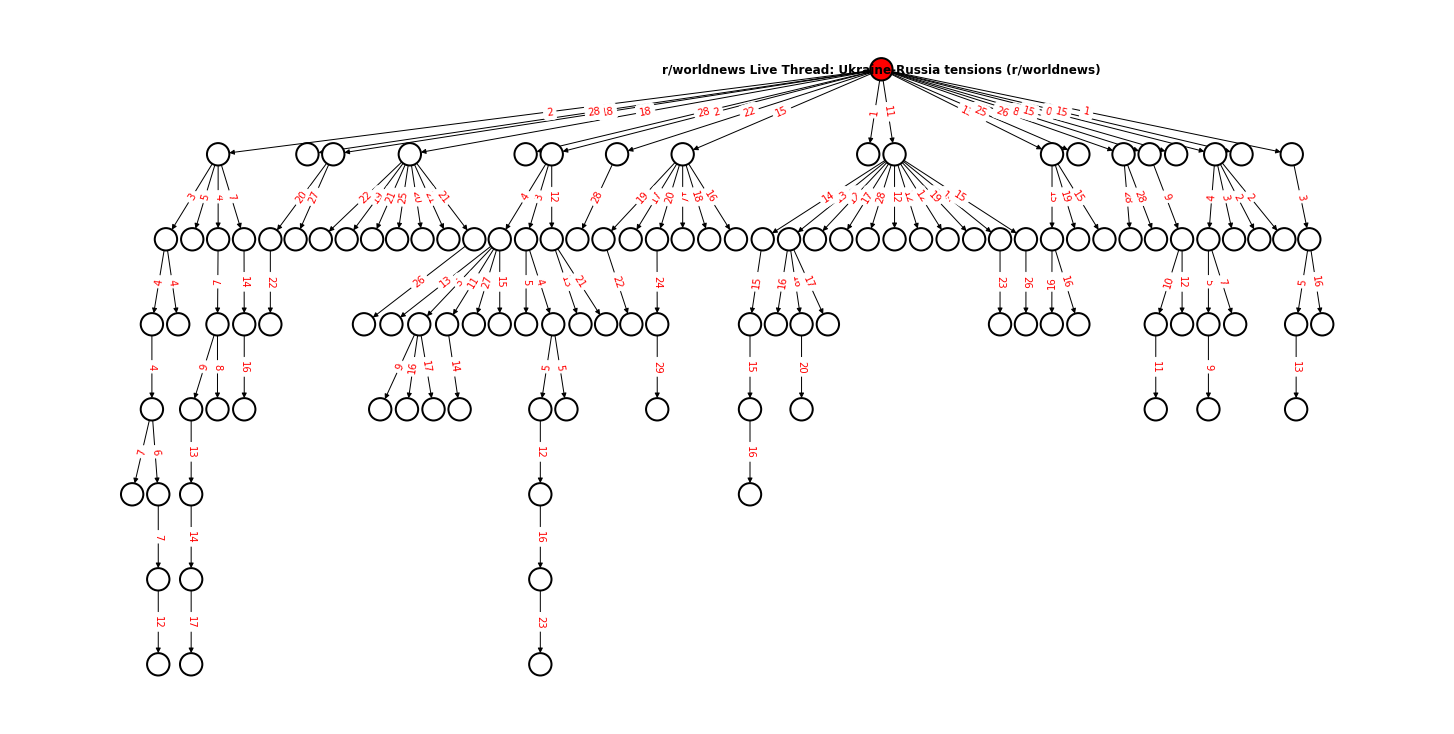

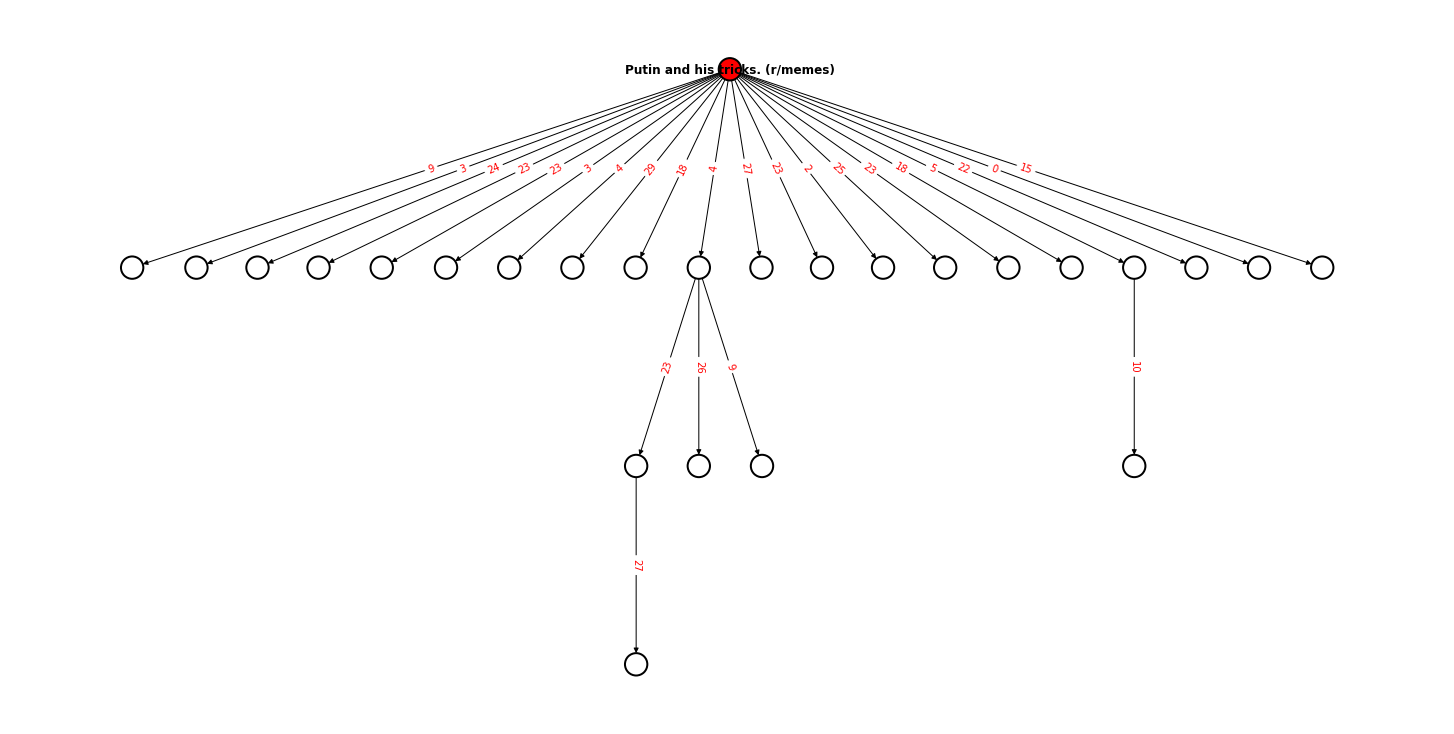

In [220]:
cnt = 3
for submission_graph in nx.weakly_connected_components(comment_forest):
    if len(submission_graph) > 10:
        H = comment_forest.subgraph(submission_graph)
        
        # node colors
        colormap = ["red" if "t3" in node else "white" for node in H.nodes()]
        
        # node labels
        node_labels = {node: "{} (r/{})".format(H.nodes[node]["link_title"], H.nodes[node]["subreddit_name"]) if "t3" in node else "" for node in H.nodes()}
        
        # edge labels: minutes since post creation (or right now as a work around: since first comment)
        edge_labels = {(u, v):  H.get_edge_data(u, v,).get("created_at") for u, v in H.edges()}
        start = min(edge_labels.values())
        step = 60
        edge_labels = {k: math.ceil((v-start) / step) for k,v in edge_labels.items()}
        
        pos=graphviz_layout(H, prog='dot')
        
        plt.figure(figsize=(20, 10))
        nx.draw(H,
                pos,
            #connectionstyle="arc3,rad=0.15",
            node_color=colormap, 
            node_size=500, 
            with_labels=True, 
            linewidths=2,
            #width=alphas, 
            edgecolors="black",
            font_weight="bold",
            labels=node_labels)
           #edge_color=colors)
        
        nx.draw_networkx_edge_labels(
            H, pos,
            edge_labels=edge_labels,
            font_color='red'
        )
        # plt.savefig("comment_tree_example.pdf")
        plt.show()
        cnt -= 1
        if cnt == 0:
            break

<h3>Temporal Interaction Graph of Users</h3>

In [10]:
# link author
# author

def create_interaction_graph(file_paths):
    G = nx.MultiDiGraph()
    comment2user = {}
    
    for file_path in tqdm(file_paths):
        with bz2.open(file_path, "rt") as file:
            for line in file:
                comment = json.loads(line)
                comment_id = comment.get("name")
                parent_id = comment.get("parent_id")
                submission_id = comment.get("link_id")
                #subreddit_id = comment.get("subreddit_id")
                #subreddit_name = comment.get("subreddit")
                author = comment.get("author")
                link_author = comment.get("link_author")
                link_title = comment.get("link_title")
                created_at = comment.get("created_utc")
                
                if not is_relevant_title(link_title):
                    continue
                    
                if parent_id == submission_id:  # top level comment
                    if submission_id not in comment2user:  #  es kann mehrere top level comments geben, also nur einmal inserten
                        comment2user[submission_id] = link_author
                        G.add_node(link_author, link_author=True)

                    comment2user[comment_id] = author
                    G.add_edge(link_author, author, created_at=created_at)
                elif parent_id in comment2user:  # only insert comment if we know the predecessor
                    comment2user[comment_id] = author
                    G.add_edge(comment2user[parent_id], author, created_at=created_at)
                    
    return G

In [11]:
files =  sorted([join(PATH + "comments/", f) for f in listdir(PATH + "comments/") 
          if isfile(join(PATH + "comments/", f))])

interaction_graph = create_interaction_graph(files[:1])

100%|██████████| 1/1 [00:09<00:00,  9.24s/it]


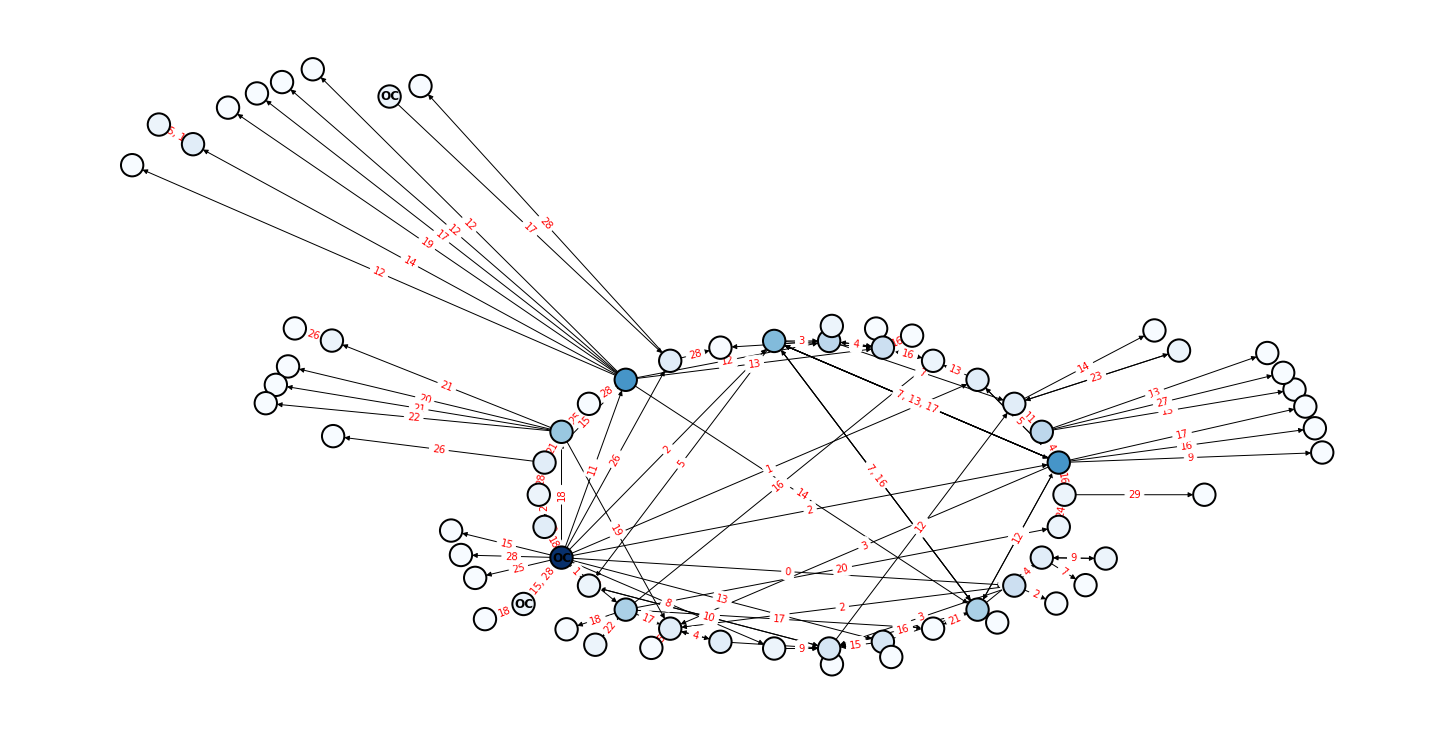

In [14]:
cnt = 1
for interaction_sub in nx.weakly_connected_components(interaction_graph):
    if len(interaction_sub) > 20:
        H = interaction_graph.subgraph(interaction_sub)

        # node colors
        node_degrees = [v for _,v in list(H.out_degree(H.nodes()))]   # list of in-degrees
        
        # node labels
        node_labels = {node: "OC" if "link_author" in H.nodes[node] else "" for node in H.nodes()}
        
        # edge labels: minutes since post creation (or right now as a work around: since first comment)
        edge_labels = {(u, v): [int(d["created_at"]) for d in H.get_edge_data(u, v).values()] for u, v in H.edges()}

        start = min(edge_labels.values(), key=lambda n: n[0])[0]
        step = 60
        edge_labels = {k: ", ".join([str(math.ceil((v-start) / step)) for v in vs]) for k,vs in edge_labels.items()}
        
        pos=graphviz_layout(H, prog='circo')
        
        plt.figure(figsize=(20, 10))
        nx.draw(H,
            pos,
            node_color=node_degrees,
            cmap=plt.cm.Blues,
            node_size=500, 
            with_labels=True, 
            linewidths=2,
            labels=node_labels,
            edgecolors="black",
            font_weight="bold")
            #width=alphas, 
            
           #edge_color=colors)
        
        nx.draw_networkx_edge_labels(H, pos,
            edge_labels=edge_labels,
            font_color='red'
        )
        plt.savefig("interaction_graph_example.pdf")
        plt.show()
        cnt -= 1
        if cnt == 0:
            break

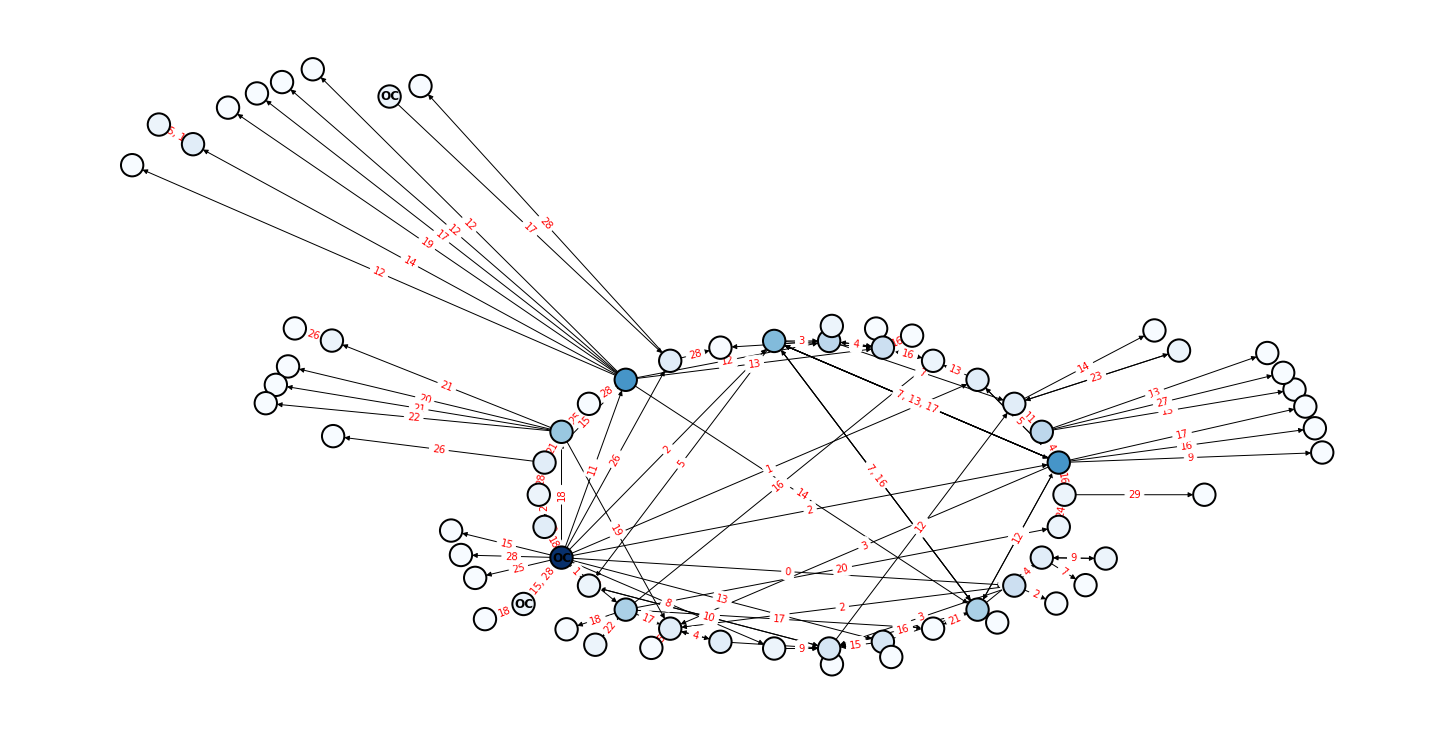

In [13]:
cnt = 1
for interaction_sub in nx.weakly_connected_components(interaction_graph):
    if len(interaction_sub) > 20:
        H = interaction_graph.subgraph(interaction_sub)

        # node colors
        node_degrees = [v for _,v in list(H.out_degree(H.nodes()))]   # list of in-degrees
        
        # node labels
        node_labels = {node: "OC" if "link_author" in H.nodes[node] else "" for node in H.nodes()}
        
        # edge labels: minutes since post creation (or right now as a work around: since first comment)
        edge_labels = {(u, v): [int(d["created_at"]) for d in H.get_edge_data(u, v).values()] for u, v in H.edges()}

        start = min(edge_labels.values(), key=lambda n: n[0])[0]
        step = 60
        edge_labels = {k: ", ".join([str(math.ceil((v-start) / step)) for v in vs]) for k,vs in edge_labels.items()}
        
        pos=graphviz_layout(H, prog='circo')
        
        plt.figure(figsize=(20, 10))
        nx.draw(H,
            pos,
            node_color=node_degrees,
            cmap=plt.cm.Blues,
            node_size=500, 
            with_labels=True, 
            linewidths=2,
            labels=node_labels,
            edgecolors="black",
            font_weight="bold")
            #width=alphas, 
            
           #edge_color=colors)
        
        nx.draw_networkx_edge_labels(H, pos,
            edge_labels=edge_labels,
            font_color='red'
        )
        #plt.savefig("interaction_graph_example.pdf")
        plt.show()
        cnt -= 1
        if cnt == 0:
            break

In [294]:
len(max(nx.weakly_connected_components(interaction_graph), key=lambda n: len(n)))

29903

<h3>Graphlets</h3>

In [344]:
H = interaction_graph.subgraph(max(nx.weakly_connected_components(interaction_graph), key=lambda n: len(n)))
str2int = {n: i for i, n in enumerate(H.nodes())}
H_numerical = nx.relabel_nodes(H, str2int, copy=True)

In [345]:
len(H_numerical.nodes())

29903

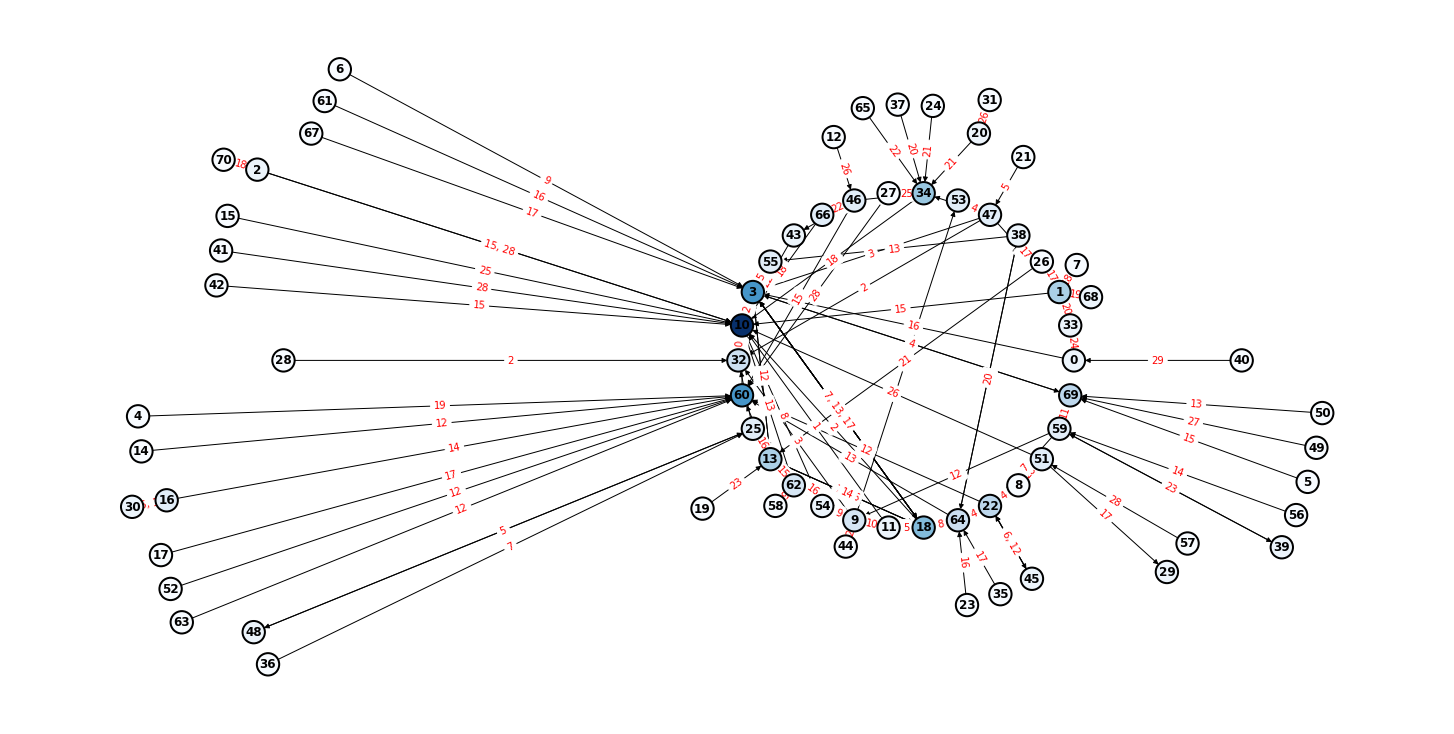

In [14]:
pos=graphviz_layout(H_numerical, prog='circo')
edge_labels = {(str2int[u], str2int[v]): x for (u,v),x in edge_labels.items()}

plt.figure(figsize=(20, 10))
nx.draw(H_numerical,
    pos,
    node_color=node_degrees,
    cmap=plt.cm.Blues,
    node_size=500, 
    with_labels=True, 
    linewidths=2,
    edgecolors="black",
    font_weight="bold")

nx.draw_networkx_edge_labels(H_numerical, pos,
    edge_labels=edge_labels,
    font_color='red'
)
plt.show()

61


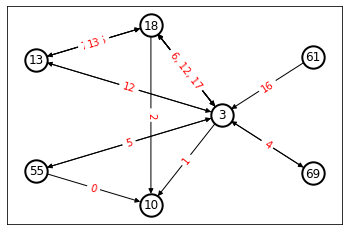

In [16]:
for n in H_numerical.nodes():
    if n != 61:
        continue
    
    ego = nx.ego_graph(H_numerical, n, 2)
    edge_labels = {(u, v): [int(d["created_at"]) for d in H_numerical.get_edge_data(u, v).values()] for u, v in ego.edges()}

    start = min(edge_labels.values(), key=lambda n: n[0])[0]
    step = 60
    edge_labels = {k: ", ".join([str(math.ceil((v-start) / step)) for v in vs]) for k,vs in edge_labels.items()}

    pos=graphviz_layout(ego, prog='circo')
    
    nx.draw_networkx(ego, pos, with_labels=True, node_color="white",linewidths=2,
    edgecolors="black", node_size=500)
    
    nx.draw_networkx_edge_labels(H_numerical, pos,
        edge_labels=edge_labels,
        font_color='red'
    )
    print(n)
    break

Persist Temporal Graph in order to Temporal Network Motifs

In [346]:
temp_edges = []
t_min = np.Inf
for u,v in H_numerical.edges():
    data = H_numerical.get_edge_data(u, v).values()
    for d in data:
        temp_edges.append((u, v, d["created_at"]))
        t_min = min(t_min, d["created_at"])
        

step = 60
temp_edges = [(u, v, math.ceil((t-t_min) / step)) for u,v,t in temp_edges]
with open("temporal_graph.csv", "w") as file:
    for u,v,t in temp_edges:
        file.write("{} {} {}\n".format(u, v, t))

<h3>Count Motifs</h3>

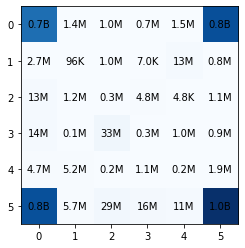

In [347]:
delta=30  # max 1h

os.system("/home/florian/snap/examples/temporalmotifs/temporalmotifsmain -i:temporal_graph.csv -o:temporal_motifs.csv -delta:{}".format(delta))

motif_cnt = np.genfromtxt("temporal_motifs.csv", delimiter=" ")
df = pd.DataFrame(motif_cnt)

def convert_label(n):
    exp = np.log10(n)
    postfix = "B" if exp > 8 else "M" if exp > 5 else "K" if exp > 2 else ""
    prefix_exp = 9 if exp > 8 else 6 if exp > 5 else 3 if exp > 2 else 0
    prefix = round(n/10**prefix_exp, 1)
    prefix = prefix if prefix < 10 else int(prefix)
    return "{}{}".format(prefix, postfix)

# plotting
fig, ax = plt.subplots()
plt.imshow(df, cmap=plt.cm.Blues)

# text
for i in range(len(df)):
    for j in range(len(df)):
        ax.text(i, j, convert_label(df[i][j]), ha="center", va="center")

plt.show()

<h3>Observe the time it takes for a motif to form</h3>

In [ ]:
motif_timeline = defaultdict(list)
delta = 1  # time for a motif to complete
t_max = max(temp_edges, key=lambda n: n[2])[2]
for i in tqdm(range(math.ceil(t_max/delta))):  # computes the bin with interval delta*i
    os.system("/home/florian/snap/examples/temporalmotifs/temporalmotifsmain -i:temporal_graph.csv -o:temporal_motifs.csv -delta:{}".format(i*delta))
    motif_cnt = np.genfromtxt("temporal_motifs.csv", delimiter=" ")
    df = pd.DataFrame(motif_cnt)
    for ii in range(df.shape[0]):
        for jj in range(df.shape[1]):
            motif_timeline[(ii,jj)].append(df.loc[ii,jj])

 98%|█████████▊| 2143/2190 [07:14<00:09,  5.15it/s]

In [ ]:
for (a,b), vals in motif_timeline.items():
    for i in range(len(vals))[::-1]:
        if i > 0:
            vals[i] -= vals[i-1]

In [ ]:
x = [i*delta for i in range(len(motif_timeline[(0,0)]))]
fig, ax = plt.subplots()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot(x, motif_timeline[(0,0)], linewidth=3, label="M1,1")
plt.plot(x, motif_timeline[(0,5)], linewidth=3, label="M1,6", linestyle="-.")
#plt.plot(x, motif_timeline[(5,0)],linewidth=3, label="M6,1", linestyle=":")
plt.plot(x, motif_timeline[(5,5)], linewidth=3, label="M6,6", linestyle="--")


#plt.plot(x, gaussian_filter1d(motif_timeline[(0,0)], sigma=3), linewidth=3, label="M1,1")
#plt.plot(x, gaussian_filter1d(motif_timeline[(0,5)], sigma=3),linewidth=3, label="M1,6", linestyle="-.")
#plt.plot(x, gaussian_filter1d(motif_timeline[(5,0)], sigma=2),linewidth=3, label="M6,1", linestyle=":")
#plt.plot(x, gaussian_filter1d(motif_timeline[(5,5)], sigma=2), linewidth=3, label="M6,6", linestyle="--")

    
plt.xlabel("Time to complete motif (minutes)")
plt.ylabel("Number of instances")
plt.title("Motif counts over time $(Bin size: \delta = {}min)$".format(delta))
plt.xscale("log")
#plt.yscale("log")
plt.legend()
plt.gca().set_xlim(left=10)
plt.gca().set_ylim(bottom=1)
plt.show()